In [1]:
## In this notebook we will try to classify the images into different classes.
## We will use the approach followed in CIFAR-10 paper.
## The network has two convolutional layers, two fully-connected layers and finally a softmax classification layer.

##--------------------------------------------------------------------------------
## Summary : classify images into classes Using Inception model
## Author  : Venkata Srinivas Vemprala
## SourceCode : https://github.com/Hvass-Labs/TensorFlow-Tutorials
##--------------------------------------------------------------------------------

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import prettytensor as pt
import os
import InceptionModule
import pickle
import cache
import matplotlib.cm as cm


from InceptionModule import transfer_values_cache
from IPython.display import Image, display
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import random_projection
from sklearn.manifold import TSNE

In [2]:
## Lets declare some constants we will be using 
data_path = '/home/srvv/Documents/TensorFlow/DeepLearning/ImageRecognition/CIFAR10/'

img_size = 32
numChannels = 3
img_size_flat = img_size*img_size*numChannels
numClasses = 10
numExamples = 50000
numExamplesPerFile = 10000

clsNames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
## Lets define a function to read read the data
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Lets define a function to normalize images
def normalize(rawImages):
    # we read images and normalize them by (value/255)
    # convert them to [-1,img_size,img_size,numChannels]
    raw = np.array(rawImages,dtype=float)/255.0
    images = raw.reshape([-1, numChannels, img_size, img_size])
    
    ##reorder images to get the right image
    images = images.transpose([0,2,3,1])
    return images

In [4]:
##lets list all files in the directory
files = os.listdir(data_path)
print(files)

dataFiles = [file for file in files if 'data_batch' in file]
print(dataFiles)

['test_batch', 'batches.meta', 'data_batch_4', 'readme.html', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_5']
['data_batch_4', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_5']


In [5]:
## Lets join data from all files into one big file

images = np.zeros(shape=[numExamples,img_size,img_size,numChannels],dtype=np.float32)
labels = np.zeros(shape=[numExamples],dtype=int)

for i,file in enumerate(dataFiles):
    dict = unpickle(os.path.join(data_path,file))
    rawImages = dict[b'data']
    dataLabels = dict[b'labels']
    begin = i*numExamplesPerFile
    end = (i+1)*numExamplesPerFile
    images[begin:end,:] = normalize(rawImages)
    labels[begin:end] = dataLabels

print(np.shape(labels))
print(np.shape(images))

(50000,)
(50000, 32, 32, 3)


In [6]:
## Now since labels are in form of argmax we need to get them one hot encoded

def convertToOneHot(vector, num_classes=None):
    assert isinstance(vector, np.ndarray)
    assert len(vector) > 0

    result = np.zeros(shape=(len(vector), numClasses))
    result[np.arange(len(vector)), vector] = 1
    return result.astype(int)


labelsOneHot = convertToOneHot(labels)
print(np.shape(labelsOneHot))


(50000, 10)


In [7]:
## Declaring function to plot images
def plotImages(images,trueLabels,predLabels=None):
    assert len(images) == len(trueLabels) == 9
    
    #create a 3x3 subplot
    (fig,axes) = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.6,wspace=1.5)
    for i,ax in enumerate(axes.flat):
        ax.imshow(images[i],interpolation='spline16')
        
        if predLabels is None:
            xlabel = 'True : '+clsNames[int(trueLabels[i])]
        else : 
            xlabel = 'True : '+clsNames[int(trueLabels[i])]+' Pred : '+clsNames[predLabels[i]]
            
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

In [8]:
##lets write a function to print weights
def printConfMatrix(trueLabels,predLabels):
    cm = confusion_matrix(y_true=trueLabels,y_pred=predLabels)
    print(cm)

##Function to print wrong examples    
def printExampleErrors(images,trueLabels,predLabels):
    correct = np.equal(trueLabels,predLabels)
    indexes = np.where(correct==False)
    
    incorrectImages = images[indexes]
    incorrectTrueLabels = trueLabels[indexes]
    incorrectPredLabels = predLabels[indexes]
    plotImages(incorrectImages[0:9,:],incorrectTrueLabels[0:9],incorrectPredLabels[0:9])

In [9]:
## Now lets download the inception module
## We have written a helper class in InceptionModule.py to load the model 
## We can use the class to classify some images

model = InceptionModule.InceptionModule()

In [10]:
## Now lets declare a file to which we want to store the output of transfer layer
filePath = 'inception/transferlayerOutputs.pkl'

## Now lets write them to file above
imagesScaled = images*255.0

def loadTrainValues(path):
    if(path and os.stat(path).st_size==0):
        print('File is not exsisting or empty.\n Reading from inception module......')
        transfer_values_train = InceptionModule.process_images(fn=model.transfer_values,images=imagesScaled)
        pickle.dump(transfer_values_train,open(path,'wb'))
    else:
        print('Reading data from file at : ',path)
        transfer_values_train = pickle.load(open(path,'rb'))
    
    print('shape : ',np.shape(transfer_values_train))
    return transfer_values_train

transfer_values_train = loadTrainValues(filePath)

Reading data from file at :  inception/transferlayerOutputs.pkl
shape :  (50000, 2048)


In [11]:
## Now lets reduce the dimensionality of the data to 2
## Kindly note that we are using Random projections here for speed
## and we have enough number of examples and dimensions following 
## bound by the "Johnson-Lindenstrauss lemma"

randProjec = random_projection.GaussianRandomProjection(n_components=2)
transferTrainTransformed = randProjec.fit_transform(transfer_values_train)
print(np.shape(transferTrainTransformed))

(50000, 2)


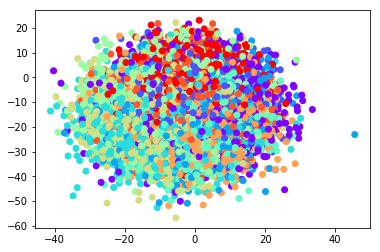

In [12]:
## Now lets write a function to plot them

def plotClasses(values,cls):
    # check the size of data and classes are same
    assert len(values) == len(cls)
    
    # Assign different color for each class
    array = np.linspace(0,1,num=10)
    cmap = cm.rainbow(array)
    colors = cmap[cls]
    
    x = values[:,0]
    y = values[:,1]
    
    # lets plot the data
    plt.scatter(x,y,color=colors)
    plt.show()
    
plotClasses(transferTrainTransformed,labels)

In [13]:
# Now lets construct a neural Network to classify images

# placeholders 
x = tf.placeholder(tf.float32,shape=[None,2048])
y_true = tf.placeholder(tf.float32,shape=[None,numClasses])

# Pretty Tensor
x_pretty = pt.wrap(x)

# Model Declaration
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred,loss = x_pretty.fully_connected(size=512,name='layerfc1').\
            fully_connected(size=64,name='layerfc2').\
            softmax_classifier(num_classes=numClasses, labels=y_true)
            
## accuracy
correct = tf.equal(tf.argmax(y_pred,dimension=1),tf.argmax(y_true,dimension=1))
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
            
##Optimization
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

In [14]:
## Saver function to save best stopping. We are exploring early stopping here
saver = tf.train.Saver()
saveDir = 'savedState/'
if not os.path.exists(saveDir):
    os.makedirs(saveDir)
savePath = os.path.join(saveDir, 'best_validation_IncepCIFAR')    

In [15]:
##Lets write a function to get the weights from this pretty tensor

# Retrieve an existing variable named 'weights' in the scope
# with the given layer_name.
def getWeights(layerName):
    with tf.variable_scope(layerName,reuse=True):
        variable = tf.get_variable('weights')
        
    return variable

In [16]:
weights1 = getWeights('layerfc1')
weights2 = getWeights('layerfc2')

In [17]:
## lets start running the graph
session = tf.Session()
session.run(tf.global_variables_initializer())

def runOptimization(numIter):
    ## Initialize variables for accuracies.For early stopping we should stop at point
    ## where the testing accuracies don't improve.
    bestAccuracy = 0.0
    lastImprIter = 0
    maxIterWithOutImpr = 2
    curIteration = 0
    for i in range(0,numIter):
        curIteration = curIteration+1
        batchSize = 1000
        startTime = time.time()
        numIterations = int(len(labelsOneHot)/batchSize)
        
        for j in range(0,numIterations):
            x_batch = transfer_values_train[(i*batchSize):(i+1)*batchSize,:]
            y_batch = labelsOneHot[(i*batchSize):(i+1)*batchSize]
            
            feed = {x:x_batch,y_true:y_batch}
            session.run(optimizer,feed_dict=feed)
            
        labelsTrain = session.run(y_pred,feed_dict={x:transfer_values_train,y_true:labelsOneHot})
        ##labelsTest = session.run(y_pred,feed_dict={x:data.test.images,y_true:data.test.labels})
        w1 = session.run(weights1,feed_dict={x:transfer_values_train,y_true:labelsOneHot})
        w2 = session.run(weights2,feed_dict={x:transfer_values_train,y_true:labelsOneHot})
        
        accuracyTrain = session.run(accuracy,feed_dict={x:transfer_values_train,y_true:labelsOneHot})
        ##accuracyTest = session.run(accuracy,feed_dict={x:data.test.images,y_true:data.test.labels})
        
        #if accuracy improves at least 0.1%
        if((accuracyTrain-bestAccuracy)>=0.001):
            bestAccuracy = accuracyTrain
            lastImprIter = curIteration
            ##Save the state
            saver.save(sess=session,save_path=savePath)
            isImproved = '*'
        else:
            isImproved = ''
        
        print('Iteration ',str(i),':-  ','Training accuracy : ',accuracyTrain*100,str(isImproved))
        print('Time Taken : ',str(time.time()-startTime),'seconds')
        
        if(curIteration-lastImprIter>maxIterWithOutImpr):
            print('No improvements in testing accuracy for a while. Performing \'Early Stopping\'')
            break
            
    return labelsTrain,w1,w2

In [18]:
labelsTrain,w1,w2 = runOptimization(2)

Iteration  0 :-   Training accuracy :  82.5039982796 *
Time Taken :  23.426715850830078 seconds
Iteration  1 :-   Training accuracy :  83.7679982185 *
Time Taken :  22.55302596092224 seconds


In [19]:
printConfMatrix(labels,np.argmax(labelsTrain,axis=1))

[[4085   66  240   12   63   46   35   40  272  141]
 [  44 4617    7    1   15   25    8    2   25  256]
 [  73    7 4190   35  241  167  189   66   24    8]
 [  52   26  224 2385  222 1593  321  117   12   48]
 [  31    1  193   26 4231  128   96  269   14   11]
 [  11    2   58   81   76 4610   35  115    2   10]
 [   9    3  189   50  156   81 4498    8    2    4]
 [  62    5   68   18  301  249    5 4247   20   25]
 [ 213   97   36   16   12   29   15    3 4459  120]
 [  81  236    7    4   17   21   12   13   47 4562]]


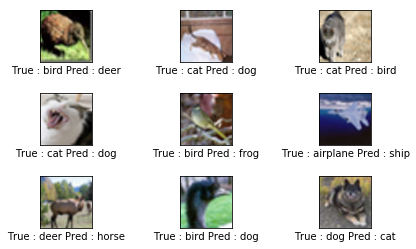

In [20]:
## lets print example errors
printExampleErrors(images,labels,np.argmax(labelsTrain,axis=1))

In [21]:
labelsTrain,w1,w2 = runOptimization(10)

Iteration  0 :-   Training accuracy :  85.8680009842 *
Time Taken :  22.313190937042236 seconds
Iteration  1 :-   Training accuracy :  85.9740018845 *
Time Taken :  22.56433343887329 seconds
Iteration  2 :-   Training accuracy :  86.5000009537 *
Time Taken :  22.259079694747925 seconds
Iteration  3 :-   Training accuracy :  87.3179972172 *
Time Taken :  22.27693223953247 seconds
Iteration  4 :-   Training accuracy :  87.6420021057 *
Time Taken :  22.321288347244263 seconds
Iteration  5 :-   Training accuracy :  87.9199981689 *
Time Taken :  22.266294956207275 seconds
Iteration  6 :-   Training accuracy :  87.797999382 
Time Taken :  22.22928261756897 seconds
Iteration  7 :-   Training accuracy :  88.6380016804 *
Time Taken :  22.23340129852295 seconds
Iteration  8 :-   Training accuracy :  88.7300014496 
Time Taken :  22.205873250961304 seconds
Iteration  9 :-   Training accuracy :  89.1499996185 *
Time Taken :  22.209018230438232 seconds


In [22]:
printConfMatrix(labels,np.argmax(labelsTrain,axis=1))

[[4582   27   40   48   32    6   10   10  167   78]
 [  52 4662    5   30    6    2    3    2   44  194]
 [ 160    1 4169  162  179   44  208   46   27    4]
 [  47    6   88 4152   91  356  166   54   12   28]
 [  48    2  134  155 4290   66  100  192    7    6]
 [   9    3   39  476   51 4262   56   90    6    8]
 [  21    1   61  158   64   16 4663    7    4    5]
 [  47    2   38   83  193   94    9 4514   13    7]
 [ 203   36    6   35   21    4   12    3 4634   46]
 [  85  161    3   31   13    2    5    4   49 4647]]


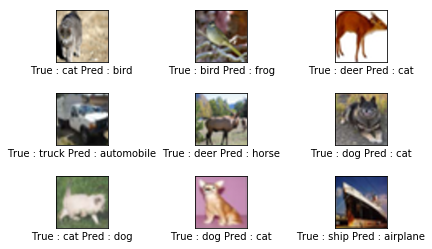

In [23]:
## lets print example errors
printExampleErrors(images,labels,np.argmax(labelsTrain,axis=1))